# Borrower reliability study

The customer is the credit department of the bank. It is necessary to find out whether the marital status and the number of children of the client affect the fact of repaying the loan on time. Input data from the bank - statistics on the solvency of customers.

The results of the study will be taken into account when building a **credit scoring** model - a special system that evaluates the ability of a potential borrower to repay a loan to a bank.

## Step 1. Open the data file and examine the general information

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv('/datasets/data.csv')
df.info()
print()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
children            21525 non-null int64
days_employed       19351 non-null float64
dob_years           21525 non-null int64
education           21525 non-null object
education_id        21525 non-null int64
family_status       21525 non-null object
family_status_id    21525 non-null int64
gender              21525 non-null object
income_type         21525 non-null object
debt                21525 non-null int64
total_income        19351 non-null float64
purpose             21525 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB



,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,-8437.673028,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья
1,1,-4024.803754,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля
2,0,-5623.422610,33,Среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья
3,3,-4124.747207,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование
4,0,340266.072047,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу


In [2]:
df.describe()

,children,days_employed,dob_years,education_id,family_status_id,debt,total_income
count,21525.000000,19351.000000,21525.000000,21525.000000,21525.000000,21525.000000,1.935100e+04
mean,0.538908,63046.497661,43.293380,0.817236,0.972544,0.080883,1.674223e+05
std,1.381587,140827.311974,12.574584,0.548138,1.420324,0.272661,1.029716e+05
min,-1.000000,-18388.949901,0.000000,0.000000,0.000000,0.000000,2.066726e+04
25%,0.000000,-2747.423625,33.000000,1.000000,0.000000,0.000000,1.030532e+05
50%,0.000000,-1203.369529,42.000000,1.000000,0.000000,0.000000,1.450179e+05
75%,1.000000,-291.095954,53.000000,1.000000,1.000000,0.000000,2.034351e+05
max,20.000000,401755.400475,75.000000,4.000000,4.000000,1.000000,2.265604e+06


In [3]:
#count duplicates before changes
duplicates_original = df.duplicated().sum()

**Conclusions**

* there are gaps in the days_employed and total_income columns
* deal with gaps and values in days_employed
* education is written in different registers, you need to make the whole table .lower()
* values in children and gender

## Step 2. Data preprocessing


### Missing values processing

In [4]:
df.isna().sum()

children               0
days_employed       2174
dob_years              0
education              0
education_id           0
family_status          0
family_status_id       0
gender                 0
income_type            0
debt                   0
total_income        2174
purpose                0
dtype: int64

There are gaps in days_employed and total_income, the number is the same. <div>
I will check whether the omissions of one value correspond to another.

In [5]:
#%pip install missingno
#import missingno as msno
#msno.heatmap(df) 
#another way to see gap matching

df[df['days_employed'].isna() & df['total_income'].isna()].shape

(2174, 12)

The gaps in days_employed correspond to the gaps in total_income. I will write the data with gaps into a separate DataFrame for the convenience of analysis.

In [6]:
df_na = df[df['days_employed'].isna()]

I'll start with gaps in income. To do this, I will study the data in more detail.

In [7]:
print(
    'Distribution by sex and type of income', df['gender'].value_counts(), 
    df['income_type'].value_counts(), sep='\n\n', end = '\n\n\n'
)
print(
    'Breakdowns by sex and income type \n in missing data', 
    df_na['gender'].value_counts(), df_na['income_type'].value_counts(), sep='\n\n'
)

Распеределения по полу и типу доходов

F      14236
M       7288
XNA        1
Name: gender, dtype: int64

сотрудник          11119
компаньон           5085
пенсионер           3856
госслужащий         1459
предприниматель        2
безработный            2
в декрете              1
студент                1
Name: income_type, dtype: int64


Распеределения по полу и типу доходов 
 в данных с пропусками

F    1484
M     690
Name: gender, dtype: int64

сотрудник          1105
компаньон           508
пенсионер           413
госслужащий         147
предприниматель       1
Name: income_type, dtype: int64


It can be seen that in the data with gaps, the gender and type of income are distributed in the same way as in the data without gaps. Also, using .value_counts(), I checked the remaining columns (I don’t give them here), I didn’t find any links between gaps and values in other columns. <div> There is one value 'XNA' instead of specifying gender, I will change it to 'F' as there are more women in the data.

In [8]:
df = df.replace('XNA', 'F')

I'll see how median incomes depend on gender and / or type of income.

In [9]:
df.groupby(['gender'])['total_income'].agg(['median']).reset_index() #пол/доход

,gender,median
0,F,134157.284057
1,M,167714.343716


In [10]:
#gender/type/income
df.pivot_table(index=['gender'], columns='income_type', values='total_income', aggfunc=('median'), dropna=True)

income_type,безработный,в декрете,госслужащий,компаньон,пенсионер,предприниматель,сотрудник,студент
gender,,,,,,,,
F,202722.511368,53829.130729,136982.489425,160861.198372,115807.789733,499163.144947,130615.610597,NaN
M,59956.991984,NaN,185964.946748,196818.800823,130739.759955,NaN,162161.177474,98201.625314


Median incomes differ by gender and type of income. I will fill in the income gaps based on this relationship. Except for one exception: there is one entrepreneur in the missing data, and there are two in total. In this case, it makes no sense to take the median income of entrepreneurs; I will fill this value with the median income of people of the same sex.

In [12]:
#first find and substitute the median income of the entrepreneur
df.loc[(df['income_type']=='предприниматель') & (df['total_income'].isna()), 'total_income'] = df[df['gender']=='M']['total_income'].median()

#the rest
df['total_income'] = df.groupby(['gender', 'income_type'])['total_income'].transform(lambda x: x.fillna(x.median()))

In [13]:
df[df['days_employed'].isna()].head()

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
12,0,NaN,65,среднее,1,гражданский брак,1,M,пенсионер,0,130739.759955,сыграть свадьбу
26,0,NaN,41,среднее,1,женат / замужем,0,M,госслужащий,0,185964.946748,образование
29,0,NaN,63,среднее,1,Не женат / не замужем,4,F,пенсионер,0,115807.789733,строительство жилой недвижимости
41,0,NaN,50,среднее,1,женат / замужем,0,F,госслужащий,0,136982.489425,сделка с подержанным автомобилем
55,0,NaN,54,среднее,1,гражданский брак,1,F,пенсионер,1,115807.789733,сыграть свадьбу


Let's move on to the gaps in 'days_employed'.

In [14]:
df[df['days_employed']>0]['income_type'].value_counts()

пенсионер      3443
безработный       2
Name: income_type, dtype: int64

In [15]:
df.groupby('income_type')['days_employed'].agg(['mean']).reset_index()

,income_type,mean
0,безработный,366413.652744
1,в декрете,-3296.759962
2,госслужащий,-3399.896902
3,компаньон,-2111.524398
4,пенсионер,365003.491245
5,предприниматель,-520.848083
6,сотрудник,-2326.499216
7,студент,-578.751554


For pensioners and the unemployed, the values ​​of the number of working days are positive, while for all the rest, they are negative. Also, the values ​​themselves, if translated into years, are about 900 years. I can’t say exactly what led to such values, but my assumption is as follows: the sign indicates the very fact of work (pensioners and the unemployed are positive and do not work), and the value for pensioners and the unemployed is probably written in hours, then it turns out that the average length of service approximately 40 years old. <div> Since the results do not take into account the experience and until I see that I need information about the experience to test hypotheses, I will not look for the reasons for these strange values, and I will replace the gaps with average values.

In [16]:
df['days_employed'] = df['days_employed'].fillna(df.groupby('income_type')['days_employed'].transform('mean'))

In [17]:
df[df.isna()].count() #I will check that there are no more missing values

children            0
days_employed       0
dob_years           0
education           0
education_id        0
family_status       0
family_status_id    0
gender              0
income_type         0
debt                0
total_income        0
purpose             0
dtype: int64

**Conclusions:**
* there were gaps in 'days_employed' and corresponding gaps in 'total_income' in the amount of 10% of the total data,
* I have replaced gaps in income with median values, and experience with average values ​​depending on gender and type of income,
* I did not find links between gaps and other values ​​and I believe that they are random,
* possible reasons for omissions: the bank does not have information about the income and experience of some people (for example, they are new clients and this information has not yet been received, or they have not provided information at all), an accidental technical error when recording. I'm leaning towards a technical error, because if people hadn't reported income and length of service, they wouldn't have provided other information (type of income, marital status, children), and there are no gaps. Well, or someone for educational purposes introduced gaps in exactly 10% of the data.

### Replacing the data type

All categorical variables are written as strings, and quantitative variables as numbers. But for speed, you can replace float with int - we don't need such accuracy in experience and income in this case.

In [18]:
df['days_employed'] = df['days_employed'].astype('int')
df['total_income'] = df['total_income'].astype('int')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
children            21525 non-null int64
days_employed       21525 non-null int64
dob_years           21525 non-null int64
education           21525 non-null object
education_id        21525 non-null int64
family_status       21525 non-null object
family_status_id    21525 non-null int64
gender              21525 non-null object
income_type         21525 non-null object
debt                21525 non-null int64
total_income        21525 non-null int64
purpose             21525 non-null object
dtypes: int64(7), object(5)
memory usage: 2.0+ MB


**Conclusion:**
* replaced float with int.

### Handling duplicates

Before removing duplicates, I will get rid of the remaining artifacts in the data: first I look at the unique values in marital status, education and children, and then I check that education_id and family_status_id match their columns

In [20]:
df['family_status'].value_counts()

женат / замужем          12380
гражданский брак          4177
Не женат / не замужем     2813
в разводе                 1195
вдовец / вдова             960
Name: family_status, dtype: int64

In [21]:
df['education'].value_counts()

среднее                13750
высшее                  4718
СРЕДНЕЕ                  772
Среднее                  711
неоконченное высшее      668
ВЫСШЕЕ                   274
Высшее                   268
начальное                250
Неоконченное высшее       47
НЕОКОНЧЕННОЕ ВЫСШЕЕ       29
НАЧАЛЬНОЕ                 17
Начальное                 15
ученая степень             4
Ученая степень             1
УЧЕНАЯ СТЕПЕНЬ             1
Name: education, dtype: int64

In [22]:
#convert everything to lowercase
df['education'] = df['education'].str.lower()
df['family_status'] = df['family_status'].str.lower()

In [23]:
df['children'].value_counts()

 0     14149
 1      4818
 2      2055
 3       330
 20       76
-1        47
 4        41
 5         9
Name: children, dtype: int64

Twenty children is possible, but unlikely. Minus one child is also clearly a mistake. Change 20 to 2 and -1 to 1.

In [24]:
df['children'] = df['children'].replace({20:2, -1:1})

In [25]:
df.groupby('family_status')['family_status_id'].unique()

family_status
в разводе                [3]
вдовец / вдова           [2]
гражданский брак         [1]
женат / замужем          [0]
не женат / не замужем    [4]
Name: family_status_id, dtype: object

In [26]:
df.groupby('education')['education_id'].unique()

education
высшее                 [0]
начальное              [3]
неоконченное высшее    [2]
среднее                [1]
ученая степень         [4]
Name: education_id, dtype: object

id is ok!

In [27]:
df['purpose'].value_counts()

свадьба                                   797
на проведение свадьбы                     777
сыграть свадьбу                           774
операции с недвижимостью                  676
покупка коммерческой недвижимости         664
покупка жилья для сдачи                   653
операции с жильем                         653
операции с коммерческой недвижимостью     651
покупка жилья                             647
жилье                                     647
покупка жилья для семьи                   641
строительство собственной недвижимости    635
недвижимость                              634
операции со своей недвижимостью           630
строительство жилой недвижимости          626
покупка недвижимости                      624
строительство недвижимости                620
покупка своего жилья                      620
ремонт жилью                              612
покупка жилой недвижимости                607
на покупку своего автомобиля              505
заняться высшим образованием      

I don’t see different registers and obvious errors here, I’ll leave it for lemmatization.

I will check the number of duplicates in the data before and after all corrections.

In [28]:
duplicates_original

54

In [29]:
df.duplicated().sum() #after

71

After fixes, there are more duplicates!

In [30]:
df =  df.drop_duplicates().reset_index(drop = True)

**Conclusion:**
* removed 54 explicit and 17 implicit duplicates.

In [31]:
df.duplicated().sum()

0

### Lemmatization

In [32]:
from pymystem3 import Mystem
m = Mystem()
from collections import Counter

In order not to lemmatize the entire df, I will write unique values ​​of goals and their number into the purpose variable. Next, I will cycle through this series and lemmatize the unique value multiplied by its number. I'll put everything in lemmas and see the frequency of lemmas.

In [33]:
purpose = df['purpose'].value_counts()
lemmas = []

for i in range(len(purpose)):
    for j in range(purpose[i]):
        lemmas.extend(m.lemmatize(purpose.index[i]))

Counter(lemmas).most_common()

[(' ', 33570),
 ('\n', 21454),
 ('недвижимость', 6351),
 ('покупка', 5897),
 ('жилье', 4460),
 ('автомобиль', 4306),
 ('образование', 4013),
 ('с', 2918),
 ('операция', 2604),
 ('свадьба', 2324),
 ('свой', 2230),
 ('на', 2222),
 ('строительство', 1878),
 ('высокий', 1374),
 ('получение', 1314),
 ('коммерческий', 1311),
 ('для', 1289),
 ('жилой', 1230),
 ('сделка', 941),
 ('дополнительный', 906),
 ('заниматься', 904),
 ('проведение', 768),
 ('сыграть', 765),
 ('сдача', 651),
 ('семья', 638),
 ('собственный', 635),
 ('со', 627),
 ('ремонт', 607),
 ('подержанный', 486),
 ('подержать', 478),
 ('приобретение', 461),
 ('профильный', 436)]

It can be seen that if you skip spaces and newlines, then the 10 most common values ​​are: 'real estate', 'purchase', 'housing', 'car', 'education', 'from', 'operation', 'wedding', ' own', 'on'. Throw out 'operation' and 'purchase', leaving the nouns 'real estate', 'housing', 'car', 'education' and 'wedding'. Real estate and housing in this case are synonyms, a total of four categories.

To answer the question about the relationship between the purpose of the loan and repayment on time, it is necessary to categorize by purpose. From the list of unique goals above, you can see that there are four final goals in total:
* wedding
* real estate
* automobile
* education

I'll write a function that will take a string with the purpose of the loan and return the category.

In [34]:
def purpose_category(cell):
    if 'свадьба' in m.lemmatize(cell):
        return 'свадьба'
    if 'жилье' in m.lemmatize(cell) or 'недвижимость' in m.lemmatize(cell):
        return 'недвижимость'
    if 'автомобиль' in m.lemmatize(cell):
        return 'автомобиль'
    if 'образование' in m.lemmatize(cell):
        return 'образование'
    return 'undefined'
    

**Conclusion:**
* written function lemmatized and categorized loan goals.

### Data categorization

I will apply the function to 'purpose' and categorize the purpose of the loan.

In [36]:
df['loan_category'] = df['purpose'].apply(purpose_category)

Perhaps it is worth dividing the income by category? Let's look at the distribution of income:

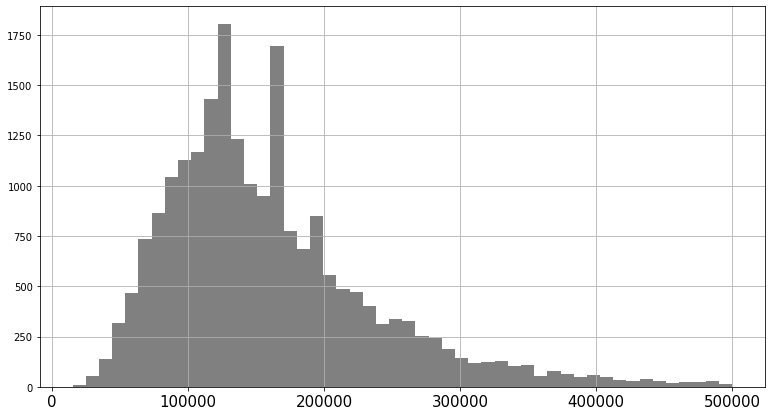

In [37]:
df['total_income'].hist(bins=50, figsize = (13, 7), xlabelsize=15, color = 'grey', range = (15000, 500000))

Let me break it down into 3 categories:
* low (up to 25th percentile)
* averages (from 25th to 75th percentile)
* high (from 75th percentile)

In [38]:
df['total_income'].describe()

count    2.145400e+04
mean     1.653174e+05
std      9.828163e+04
min      2.066700e+04
25%      1.076230e+05
50%      1.441265e+05
75%      1.968180e+05
max      2.265604e+06
Name: total_income, dtype: float64

Create a function to categorize income and apply it.

In [39]:
def income_category(cell):
    if cell<=1.076230e+05:
        return 'низкий'
    if cell<=1.968180e+05:
        return 'средний'
    return 'высокий'

df['income_category'] = df['total_income'].apply(income_category)
#df.head(20)

I'll break it down into categories based on the presence of children.

In [40]:
def children_category(cell):
    if cell==0:
        return 'без детей'
    if cell==1:
        return 'один ребенок'
    if cell==2:
        return 'двое детей'
    return 'более двух детей'

df['children_category'] = df['children'].apply(children_category)
#df.head(20)

**Conclusion:**
* Since similar goals are written differently in the 'purpose' column, I have divided the goals into categories.
* divided into categories by the number of children
* split income into three levels

## Step 3: Answer the questions

__Is there a relationship between having children and repaying the loan on time?__

To begin with, let's look at how many people on average have problems with payments. And then compare this number with people with children.

In [41]:
print('Average debt: {:.3%}'.format(df['debt'].mean()))

Задолженность в среднем: 8.115%


In [42]:
print('Debt and no children: {:.3%}'.format(df[df['children']==0]['debt'].mean()))
print('Debt and having children: {:.3%}'.format(df[df['children']>0]['debt'].mean()))
print('Debt and 1 child: {:.3%}'.format(df[df['children']==1]['debt'].mean()))
print('Debt and 2 or more children: {:.3%}'.format(df[df['children']>=2]['debt'].mean()))
print()
df_children  = pd.DataFrame(df.groupby('children')['debt'].mean().reset_index())
df_children = df_children.drop(5) #нулевое значение долга
df_children['debt'] = df_children['debt']*100
df_children

Задолженность и отсутствие детей: 7.544%
Задолженность и наличие детей: 9.208%
Задолженность и 1 ребенок: 9.166%
Задолженность и 2 и более детей: 9.290%



,children,debt
0,0,7.543822
1,1,9.165808
2,2,9.492481
3,3,8.181818
4,4,9.756098


**Conclusion:**
* The presence of children increases the probability of not repaying the loan on time by 1.7%

__Is there a relationship between marital status and loan repayment on time?__

In [43]:
df_family = pd.DataFrame(df.groupby('family_status')['debt'].mean().reset_index())
df_family['debt']=df_family['debt']*100 #convert to percentage for clarity
df_family

,family_status,debt
0,в разводе,7.112971
1,вдовец / вдова,6.569343
2,гражданский брак,9.347145
3,женат / замужем,7.545182
4,не женат / не замужем,9.750890


**Conclusion:**
* More often than not, people who are in a civil marriage or single do not repay the loan on time. Among people who are married, the percentage is close to the average. And people who are divorced or have lost their spouses have fewer problems repaying loans with due date.

__Is there a relationship between the level of income and repayment of the loan on time?__

In [52]:
df_income_cat = pd.DataFrame(df.groupby('income_category')['debt'].mean().reset_index())
df_income_cat['debt']=df_income_cat['debt']*100 #convertion to percentage
df_income_cat

,income_category,debt
0,высокий,7.121269
1,низкий,7.960477
2,средний,8.679140


**Conclusions:**
* people with average income often do not repay the loan on time

__How do different purposes of a loan affect its repayment on time?__

I will do the same as in the family situation.

In [53]:
df_loan_cat = pd.DataFrame(df.groupby('loan_category')['debt'].mean().reset_index())
df_loan_cat['debt']=df_loan_cat['debt']*100 #переведу в проценты для наглядности
df_loan_cat

,loan_category,debt
0,автомобиль,9.359034
1,недвижимость,7.233373
2,образование,9.220035
3,свадьба,8.003442


**Conclusion**
* among people who took out a loan for a car and education, there is a debt above the average by 1%, while among real estate loans, debt is minimal.

__Is there a relationship between having children and repaying the loan on time?__

In [54]:
df.pivot_table(index=['children_category'], values='debt', aggfunc='mean').sort_values(by='debt').round(3)*100

,debt
children_category,
без детей,7.5
более двух детей,8.2
один ребенок,9.2
двое детей,9.5


__Is there a relationship between marital status and loan repayment on time?__

In [55]:
df.pivot_table(index=['family_status'], values='debt', aggfunc='mean').sort_values(by='debt').round(3)*100

,debt
family_status,
вдовец / вдова,6.6
в разводе,7.1
женат / замужем,7.5
гражданский брак,9.3
не женат / не замужем,9.8


__Is there a relationship between the level of income and repayment of the loan on time?__

In [56]:
df.pivot_table(index=['income_category'], values='debt', aggfunc='mean').sort_values(by='debt').round(3)*100

,debt
income_category,
высокий,7.1
низкий,8.0
средний,8.7


__How do different purposes of a loan affect its repayment on time?__

In [57]:
df.pivot_table(index=['loan_category'], values='debt', aggfunc='mean').sort_values(by='debt').round(3)*100

,debt
loan_category,
недвижимость,7.2
свадьба,8.0
образование,9.2
автомобиль,9.4


In [58]:
#creating pivot
pivot_final = df.pivot_table(index=['children_category', 'family_status', 'income_category', 'loan_category'], 
                             values='debt', aggfunc=('mean', 'count')).reset_index()
#sorting
pivot_final = pivot_final.sort_values(by=['mean'], ascending=False)

pivot_final = pivot_final.rename(columns={'mean': 'debt'})
pivot_final['debt'] = (pivot_final['debt']*100).round(1)

#first 5 with count>100
pivot_final[pivot_final['count']>100].head()

,children_category,family_status,income_category,loan_category,count,debt
157,один ребенок,гражданский брак,средний,недвижимость,131.0,16.8
28,без детей,гражданский брак,средний,образование,138.0,15.2
155,один ребенок,гражданский брак,низкий,свадьба,129.0,14.0
163,один ребенок,женат / замужем,низкий,автомобиль,158.0,13.3
39,без детей,не женат / не замужем,высокий,автомобиль,123.0,13.0


## Step 4. General conclusion

I analyzed the debt depending on various factors:
* average debt is 8%,
* the contribution of each different factor to the debt is 1-1.5%
* people with children often do not repay the loan on time,
* marital status affects debt, unmarried people have higher debt,
* the level of income does not affect the debt,
* loans for a car and education are more "problematic" than real estate and a wedding.

In [59]:
df[(df['children']>0) & (df['loan_category']=='автомобиль') & (df['family_status_id']==4)]['debt'].mean()

0.15126050420168066

For example, unmarried people with children who take money for a car have debts that are almost 2 times higher than the average.
<div> I visualize the results.

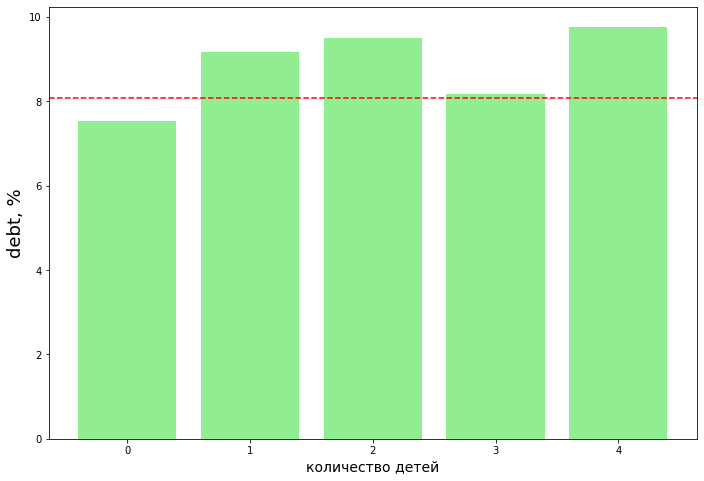

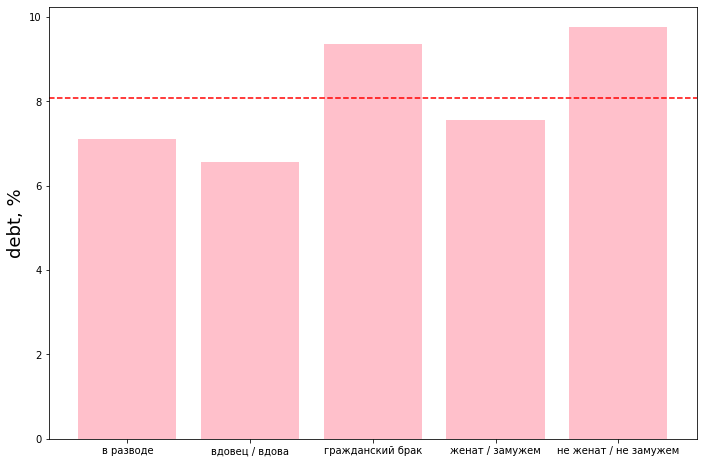

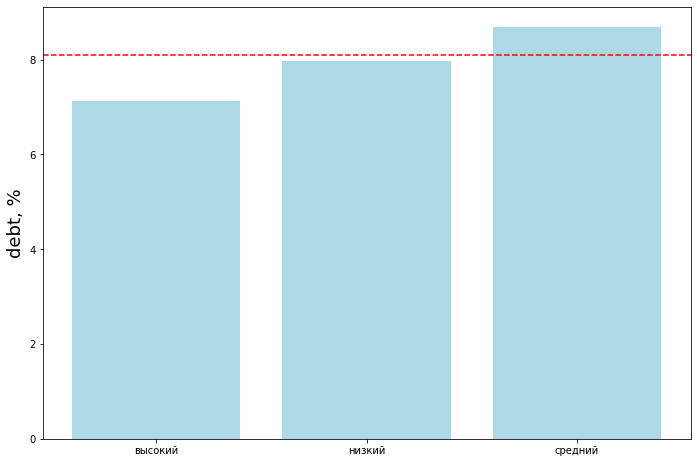

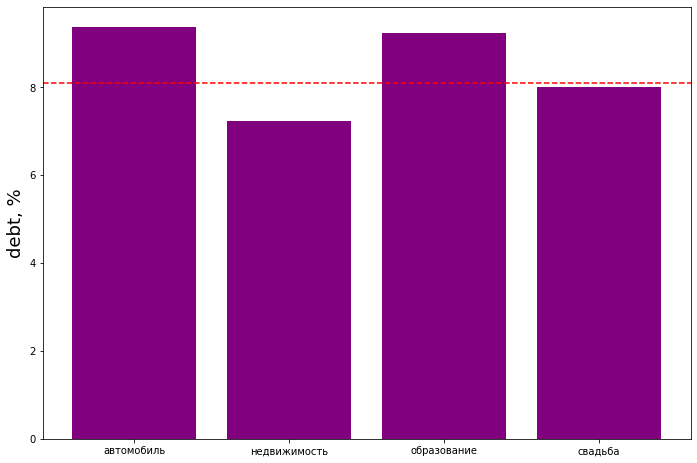

In [60]:
fig = plt.figure()
ax = fig.add_axes([0,0,1.5,1.5])
status = df_children['children']
value = df_children['debt']
ax.bar(status,value, color='lightgreen')
plt.axhline(y=8.088, color='red', linestyle='--') #average debt
plt.ylabel('debt, %', fontsize=18)
plt.xlabel('количество детей', fontsize=14)
plt.show()

fig = plt.figure()
ax = fig.add_axes([0,0,1.5,1.5])
status = df_family['family_status']
value = df_family['debt']
ax.bar(status,value, color='pink')
plt.axhline(y=8.088, color='red', linestyle='--') #average debt
plt.ylabel('debt, %', fontsize=18)
plt.show()

fig = plt.figure()
ax = fig.add_axes([0,0,1.5,1.5])
status = df_income_cat['income_category']
value = df_income_cat['debt']
ax.bar(status,value, color='lightblue')
plt.axhline(y=8.088, color='red', linestyle='--') #average debt
plt.ylabel('debt, %', fontsize=18)
plt.show()

fig = plt.figure()
ax = fig.add_axes([0,0,1.5,1.5])
status = df_loan_cat['loan_category']
value = df_loan_cat['debt']
ax.bar(status,value, color='purple')
plt.axhline(y=8.088, color='red', linestyle='--') #average debt
plt.ylabel('debt, %', fontsize=18)
plt.show()